In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.figure
import xgboost as xgb

%matplotlib inline

/Users/waihamyee/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data and Preprocessing

In [79]:
# Read the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [6]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,37,23,20,0,3,27,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,37,21,22,4,3,31,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,24,24,38,2,3,30,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,24,21,38,5,3,30,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,24,23,38,5,3,14,3,13,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,24,23,38,5,3,26,0,22,0,...,0,0,0,1,0,0,0,0,0,0
1,2,46,3,9,0,3,9,6,24,0,...,0,0,1,0,0,0,0,0,0,0
2,3,24,23,19,5,3,0,9,9,0,...,0,0,0,1,0,0,0,0,0,0
3,4,24,13,38,5,3,32,11,13,0,...,0,0,0,1,0,0,0,0,0,0
4,5,49,20,19,2,3,31,8,12,0,...,1,0,0,0,0,0,0,0,0,0


In [81]:
## Combine the datasets (train and test)
full_data = pd.concat([train.drop(["y"], axis=1), test])
print ("The training and testing data sets combined contains {} rows and {} columns"
       .format(full_data.shape[0], full_data.shape[1])
      )

The training and testing data sets combined contains 8418 rows and 377 columns


## Dimensionality Reduction

### Homogeneous Columns in Training Set

Let's look at the items in the training set that have the same value throughout all of our dataset.

In [76]:
## Select all columns in our train dataset that only have 1 unique value
train.loc[:,(train.apply(pd.Series.nunique) == 1)].columns.tolist()

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

What about in the test set? Are there any similar columns?

In [9]:
## Select all columns in our test dataset that only have 1 unique value
test.loc[:,(test.apply(pd.Series.nunique) == 1)].columns.tolist()

['X257', 'X258', 'X295', 'X296', 'X369']

In [84]:
## Let's drop the columns from the training dataset that are homogeneous 
## throughout the training set.
print("Before shape : {}".format(train.shape))
train_dropped = train.drop(train.loc[:,(train.apply(pd.Series.nunique) == 1)].columns.tolist(), axis=1)
print("After shape : {}".format(train_dropped.shape))

## We need to drop the same columns from the test dataset.
print("Before shape : {}".format(test.shape))
test_dropped = test.drop(train.loc[:,(train.apply(pd.Series.nunique) == 1)].columns.tolist(), axis=1)
print("After shape : {}".format(test_dropped.shape))

Before shape : (4209, 378)
After shape : (4209, 366)
Before shape : (4209, 377)
After shape : (4209, 365)


***

### PCA and Factor Analysis

In [7]:
from sklearn.decomposition import PCA
n_comp = 10

# PCA
pca = PCA(n_components=n_comp)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

In [123]:
from sklearn.decomposition import FactorAnalysis

n_comp = 10

# PCA
FA = FactorAnalysis(n_components=n_comp)
FA_results_train = FA.fit_transform(train.drop(["y"], axis=1))
FA_results_test = FA.transform(test)

0.99999738674424321

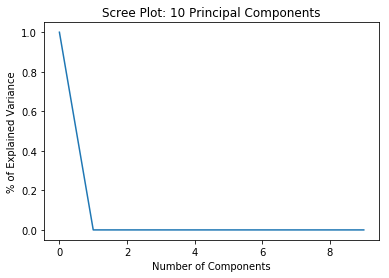

In [9]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Scree Plot: 10 Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Explained Variance")
sum(pca.explained_variance_ratio_)

***

## Machine Learning

### XGBoost
Let's try training the data on a boosted tree model. As we know, all Kagglers love XGBoost, so let's try that first.

In [132]:
## My response variables
y_train = train["y"]
## My baseline prediction: an average of the y-values
y_mean = np.mean(y_train)

# Prepare dict of params for XGBoost to run with
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

# Form DMatrices for Xgboost training
dtrain = xgb.DMatrix(train.drop(["y"],axis=1), y_train)
dtest = xgb.DMatrix(test)

# XGBoost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=10000,
                   nfold=10,
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False,
                   seed=2017
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

## Train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

## Save the model
model.save_model('models/FA.model')

[0]	train-rmse:12.6432	test-rmse:12.605
[50]	train-rmse:11.1169	test-rmse:11.0987
[100]	train-rmse:10.0689	test-rmse:10.0732
[150]	train-rmse:9.36557	test-rmse:9.39436
[200]	train-rmse:8.90223	test-rmse:8.95591
[250]	train-rmse:8.59939	test-rmse:8.67802
[300]	train-rmse:8.40164	test-rmse:8.50461
[350]	train-rmse:8.27049	test-rmse:8.39633
[400]	train-rmse:8.18082	test-rmse:8.33203
[450]	train-rmse:8.11485	test-rmse:8.29432
[500]	train-rmse:8.06248	test-rmse:8.27214
[550]	train-rmse:8.01835	test-rmse:8.25984
[600]	train-rmse:7.98092	test-rmse:8.25232
[650]	train-rmse:7.94771	test-rmse:8.24798
[700]	train-rmse:7.91572	test-rmse:8.24718
692


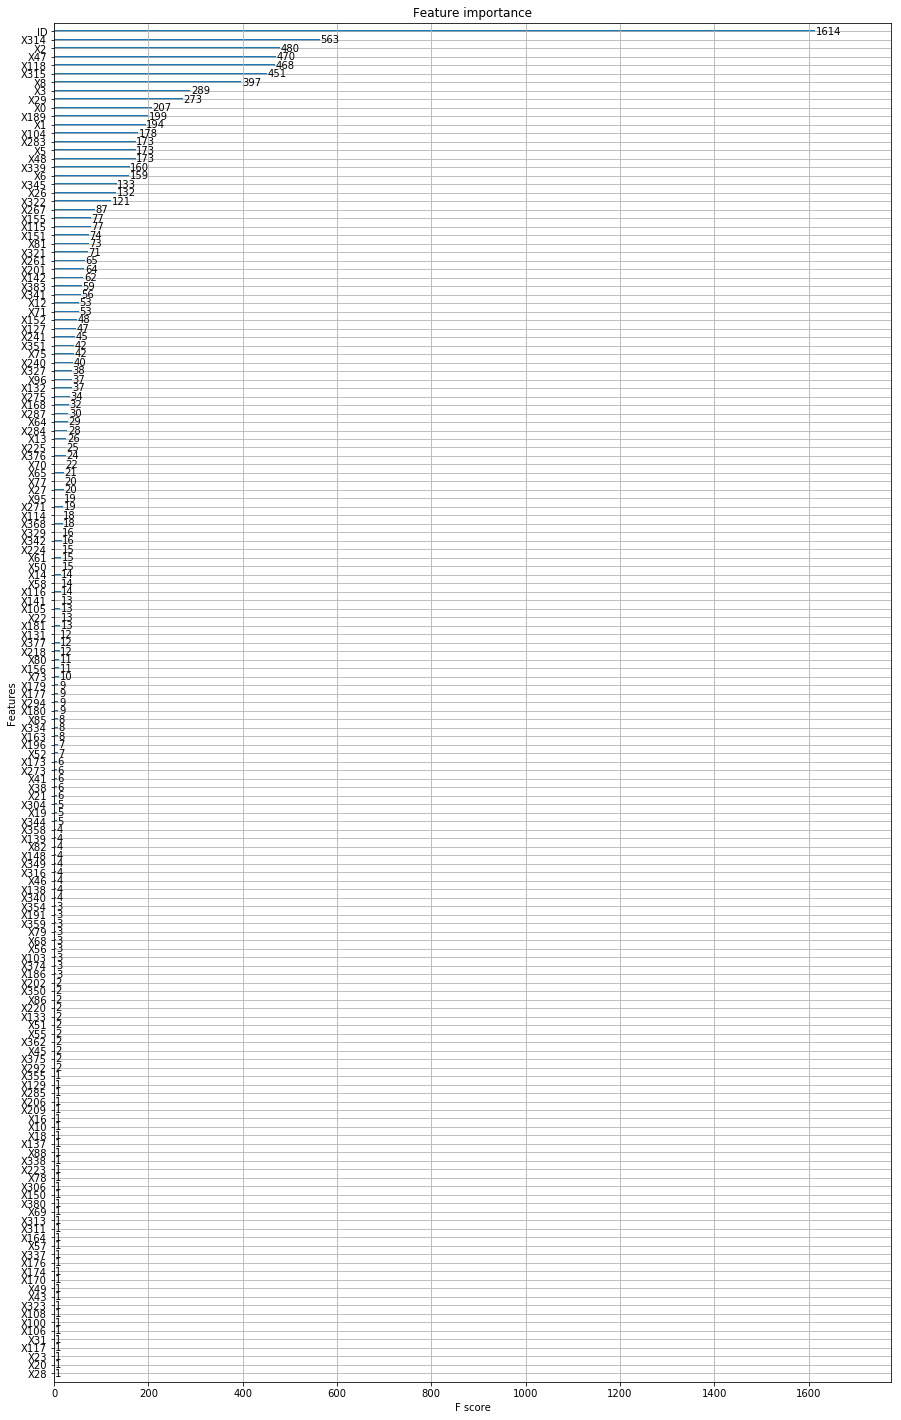

In [129]:
## Plot the feature importance plot
xgb.plot_importance(model).figure.set_size_inches( (15,25) )

In [133]:
# Check r2-score
from sklearn.metrics import r2_score

# Print out the r2-score
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.606686750893


In [134]:
# Predict on the test set and save results.
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('xgboost_700boost_500tree_2017seed_10KFCV.csv', index=False)

In [135]:
y_pred

array([  82.20593262,  102.91985321,   79.72367859, ...,   92.96769714,
        109.7268219 ,   93.63645172], dtype=float32)